# Denoising Diffusion Implicit Models

## Introduction

### What are diffusion models?

[Denoising diffusion models](https://arxiv.org/abs/2006.11239), including
[score-based generative models](https://arxiv.org/abs/1907.05600), gained popularity as a
powerful class of generative models, that can [rival](https://arxiv.org/abs/2105.05233)
even [generative adversarial networks (GANs)](https://arxiv.org/abs/1406.2661) in image
synthesis quality. They tend to generate more diverse samples, while being stable to
train and easy to scale.

Diffusion refers to the process of turning a structured signal (an image) into noise
step-by-step. By simulating diffusion, we can generate noisy images from our training
images, and can train a neural network to try to denoise them. Using the trained network
we can simulate the opposite of diffusion, reverse diffusion, which is the process of an
image emerging from noise.


In this example I made effort to break down all long mathematical expressions into
digestible pieces and gave all variables explanatory names.
In the following sections, I have implemented a continuous time version of
[Denoising Diffusion Implicit Models (DDIMs)](https://arxiv.org/abs/2010.02502)
with deterministic sampling.

## Setup

In [1]:
!pip install keras==3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops
import numpy as np

## Hyperparameters

In [3]:
# Downloading the Dataset on collab/local notebook from the drive link
!gdown http://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA
!unzip -q Samples.zip   #Using the dataset by first unzipping it.

Downloading...
From (original): http://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA
From (redirected): https://drive.google.com/uc?id=1cJyPQzVOzsCZQctNBuHCqxHnOY7v7UiA&confirm=t&uuid=ab03a5ae-af12-4364-8b08-a80de8e45986
To: /content/Samples.zip
100% 304M/304M [00:02<00:00, 138MB/s]


In [28]:
# data
dataset_repetitions = 5
num_epochs = 50  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

## Data pipeline


In [5]:
# Function to process each file
def process_file(input_file, output_folder, shape):
    """Process a single .npy file.
    Args:
    - input_file (str): Path to the input .npy file.
    - output_folder (str): Path to the output folder where processed images will be saved.
    - shape (int): Shape of the output image (assuming square images)."""

    # Load the .npy file
    data = np.load(input_file)
    data = np.repeat(data[..., np.newaxis], 3, axis=-1)
    # Normalize the data to [0, 255] range
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255

    # Convert data to uint8 datatype
    data = data.astype(np.uint8)

    # Reshape the data into image dimensions
    image_data = data.reshape(shape, shape,3)

    # Convert NumPy array to PIL Image
    image = Image.fromarray(image_data)

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save the image as a JPEG file in the output folder
    output_file = os.path.join(output_folder, os.path.basename(os.path.splitext(input_file)[0] + '.jpeg'))

    image.save(output_file)

In [6]:
from PIL import Image

# Function to loop over a folder and create another folder for all files
def process_folder(input_folder, output_folder, shape):
    """Process all .npy files in a folder and save the processed images to another folder.
    Args:
    - input_folder (str): Path to the input folder containing .npy files.
    - output_folder (str): Path to the output folder where processed images will be saved.
    - shape (int): Shape of the output images (assuming square images)."""
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                # Process each file in the folder
                process_file(file_path, output_folder, shape)

# Specify the input and output folders
input_folder = '/content/Samples'  # Path to the folder containing .npy files
output_folder = '/content/Input'   # Path to the folder where processed images will be saved

# Process the input folder and create images in the output folder
process_folder(input_folder, output_folder, 150) #150 is the shape of the image

In [7]:
clip_min = 0.0  # Minimum pixel value after clipping
clip_max = 1.0  # Maximum pixel value after clipping
img_size = 64  # Image size, since the model works on images of shape 64 x 64
img_channels = 3  # Number of channels in the images i.e. (1 for grayscale)

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    """Load and preprocess a single image file.
    Args:
    - file_path (str): Path to the image file.
    Returns:
    - img (Tensor): Preprocessed image tensor."""

    # Read image file
    img = tf.io.read_file(file_path)

    # Decode image
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image with 1 channel (grayscale)

    # Preprocess image (resize, rescale, augment as needed)
    img = resize_and_rescale(img, size=(img_size, img_size))  # Resize and rescale image
    img = augment(img)  # Augment image
    return img

In [8]:
# Define the preprocessing functions (resize, rescale, augment)
def augment(img):
    """Augment the image.
    Args:
    - img (Tensor): Input image tensor.
    Returns:
    - img (Tensor): Augmented image tensor."""
    # Example: Randomly flip image left/right

    return tf.image.random_flip_left_right(img)

In [9]:
def resize_and_rescale(img, size):
    """Resize and rescale the image.
    Args:
    - img (Tensor): Input image tensor.
    - size (tuple): Desired size of the output image (height, width).
    Returns:
    - img (Tensor): Resized and rescaled image tensor."""

    img = tf.image.resize(img, size=size, antialias=True)  # Resize image
    img = tf.cast(img, dtype=tf.float32)  # Cast image to float32
    img = img / 255.0  # Rescale image to [0, 1] range
    img = tf.clip_by_value(img, clip_min, clip_max)  # Clip pixel values to specified range
    return img

In [10]:
# Define the folder path containing images
folder_path = "/content/Input"

# Collect file paths of images in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]

# Create a TensorFlow Dataset from the file paths
image_ds = tf.data.Dataset.from_tensor_slices(file_paths)

# Map the preprocessing function to each image path
image_ds = image_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch the dataset
train_ds = image_ds.batch(batch_size, drop_remainder=True).shuffle(batch_size * 2).prefetch(tf.data.AUTOTUNE)

## Kernel inception distance

[Kernel Inception Distance (KID)](https://arxiv.org/abs/1801.01401) is an image quality
metric which was proposed as a replacement for the popular
[Frechet Inception Distance (FID)](https://arxiv.org/abs/1706.08500).
I prefer KID to FID because it is simpler to
implement, can be estimated per-batch, and is computationally lighter.

In [14]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## Network architecture

Here we specify the architecture of the neural network that we will use for denoising. We
build a [U-Net](https://arxiv.org/abs/1505.04597) with identical input and output
dimensions. U-Net is a popular semantic segmentation architecture, whose main idea is
that it progressively downsamples and then upsamples its input image, and adds skip
connections between layers having the same resolution. These help with gradient flow and
avoid introducing a representation bottleneck, unlike usual
[autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html). Based on
this, one can view
[diffusion models as denoising autoencoders](https://benanne.github.io/2022/01/31/diffusion.html)
without a bottleneck.

The network takes two inputs, the noisy images and the variances of their noise
components. The latter is required since denoising a signal requires different operations
at different levels of noise. We transform the noise variances using sinusoidal
embeddings, similarly to positional encodings used both in
[transformers](https://arxiv.org/abs/1706.03762) and
[NeRF](https://arxiv.org/abs/2003.08934). This helps the network to be
[highly sensitive](https://arxiv.org/abs/2006.10739) to the noise level, which is
crucial for good performance. We implement sinusoidal embeddings using a
[Lambda layer](https://keras.io/api/layers/core_layers/lambda/).

Some other considerations:

* We build the network using the
[Keras Functional API](https://keras.io/guides/functional_api/), and use
[closures](https://twitter.com/fchollet/status/1441927912836321280) to build blocks of
layers in a consistent style.
* [Diffusion models](https://arxiv.org/abs/2006.11239) embed the index of the timestep of
the diffusion process instead of the noise variance, while
[score-based models (Table 1)](https://arxiv.org/abs/2206.00364)
usually use some function of the noise level. I
prefer the latter so that we can change the sampling schedule at inference time, without
retraining the network.
* [Diffusion models](https://arxiv.org/abs/2006.11239) input the embedding to each
convolution block separately. We only input it at the start of the network for
simplicity, which in my experience barely decreases performance, because the skip and
residual connections help the information propagate through the network properly.
* In the literature it is common to use
[attention layers](https://keras.io/api/layers/attention_layers/multi_head_attention/)
at lower resolutions for better global coherence. I omitted it for simplicity.
* We disable the learnable center and scale parameters of the batch normalization layers,
since the following convolution layers make them redundant.
* We initialize the last convolution's kernel to all zeros as a good practice, making the
network predict only zeros after initialization, which is the mean of its targets. This
will improve behaviour at the start of training and make the mean squared error loss
start at exactly 1.

In [15]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


## Diffusion model

In [24]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=2):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                grayscale_image = np.dot(generated_images[index][..., :3], [0.2989, 0.5870, 0.1140])
                plt.imshow(grayscale_image, cmap='gray')
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


## Training

In [25]:
train_dataset = train_ds
val_dataset = train_ds

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 1.2221 - n_loss: 0.3923

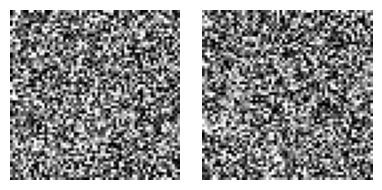

156/156 ━━━━━━━━━━━━━━━━━━━━ 142s 700ms/step - i_loss: 1.2187 - n_loss: 0.3913 - kid: 0.0000e+00 - val_i_loss: 2.5292 - val_kid: 3.1652 - val_n_loss: 0.7977
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - i_loss: 0.2214 - n_loss: 0.0845

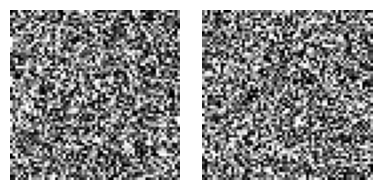

156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 706ms/step - i_loss: 0.2213 - n_loss: 0.0845 - kid: 0.0000e+00 - val_i_loss: 2.5374 - val_kid: 3.1635 - val_n_loss: 0.7970
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - i_loss: 0.1902 - n_loss: 0.0760

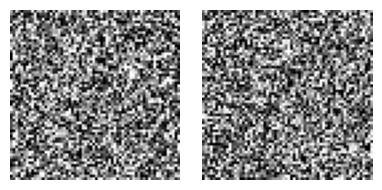

156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 716ms/step - i_loss: 0.1901 - n_loss: 0.0760 - kid: 0.0000e+00 - val_i_loss: 2.5444 - val_kid: 3.1595 - val_n_loss: 0.7934
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.1448 - n_loss: 0.0629

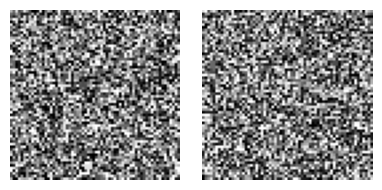

156/156 ━━━━━━━━━━━━━━━━━━━━ 142s 715ms/step - i_loss: 0.1449 - n_loss: 0.0629 - kid: 0.0000e+00 - val_i_loss: 2.5326 - val_kid: 3.1683 - val_n_loss: 0.7845
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 0.1439 - n_loss: 0.0617

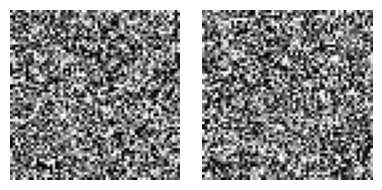

156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 504ms/step - i_loss: 0.1439 - n_loss: 0.0617 - kid: 0.0000e+00 - val_i_loss: 2.3832 - val_kid: 3.1596 - val_n_loss: 0.7685
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - i_loss: 0.1254 - n_loss: 0.0556

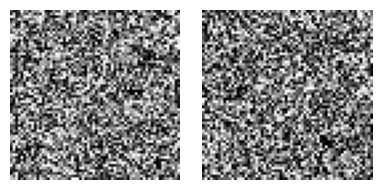

156/156 ━━━━━━━━━━━━━━━━━━━━ 84s 506ms/step - i_loss: 0.1254 - n_loss: 0.0556 - kid: 0.0000e+00 - val_i_loss: 2.2886 - val_kid: 3.1400 - val_n_loss: 0.7452
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1256 - n_loss: 0.0566

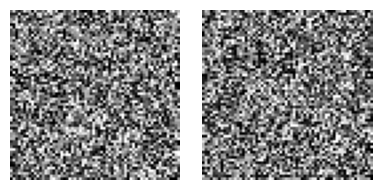

156/156 ━━━━━━━━━━━━━━━━━━━━ 172s 714ms/step - i_loss: 0.1255 - n_loss: 0.0566 - kid: 0.0000e+00 - val_i_loss: 2.1883 - val_kid: 3.1222 - val_n_loss: 0.7159
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 0.1166 - n_loss: 0.0515

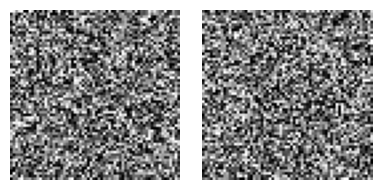

156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 717ms/step - i_loss: 0.1167 - n_loss: 0.0515 - kid: 0.0000e+00 - val_i_loss: 2.0702 - val_kid: 3.0830 - val_n_loss: 0.6806
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.1797 - n_loss: 0.0731

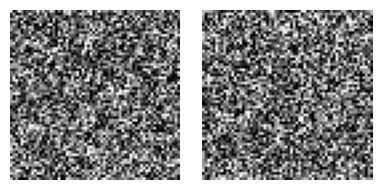

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 722ms/step - i_loss: 0.1823 - n_loss: 0.0739 - kid: 0.0000e+00 - val_i_loss: 1.9408 - val_kid: 3.0211 - val_n_loss: 0.6400
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 1.9657 - n_loss: 0.7022

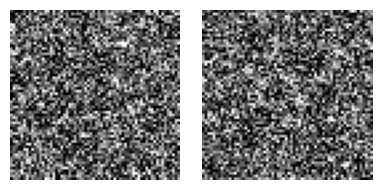

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 725ms/step - i_loss: 1.9575 - n_loss: 0.6993 - kid: 0.0000e+00 - val_i_loss: 1.7393 - val_kid: 2.9134 - val_n_loss: 0.5900
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.1649 - n_loss: 0.0679

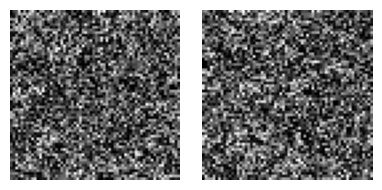

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 719ms/step - i_loss: 0.1648 - n_loss: 0.0678 - kid: 0.0000e+00 - val_i_loss: 1.5302 - val_kid: 2.8357 - val_n_loss: 0.5379
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 0.1353 - n_loss: 0.0563

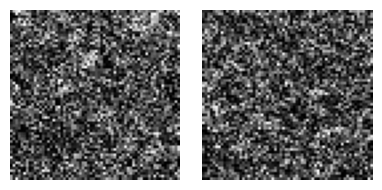

156/156 ━━━━━━━━━━━━━━━━━━━━ 111s 507ms/step - i_loss: 0.1353 - n_loss: 0.0563 - kid: 0.0000e+00 - val_i_loss: 1.3682 - val_kid: 2.7255 - val_n_loss: 0.4908
Epoch 13/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - i_loss: 0.1195 - n_loss: 0.0519

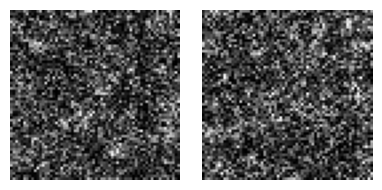

156/156 ━━━━━━━━━━━━━━━━━━━━ 172s 715ms/step - i_loss: 0.1194 - n_loss: 0.0519 - kid: 0.0000e+00 - val_i_loss: 1.2413 - val_kid: 2.6068 - val_n_loss: 0.4479
Epoch 14/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1101 - n_loss: 0.0482

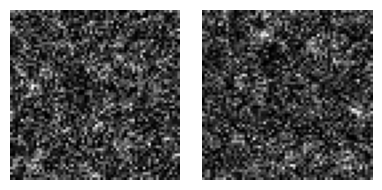

156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 724ms/step - i_loss: 0.1101 - n_loss: 0.0482 - kid: 0.0000e+00 - val_i_loss: 1.1356 - val_kid: 2.4935 - val_n_loss: 0.4086
Epoch 15/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.4902 - n_loss: 0.1732

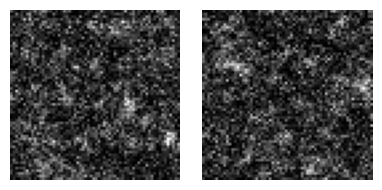

156/156 ━━━━━━━━━━━━━━━━━━━━ 85s 532ms/step - i_loss: 0.4913 - n_loss: 0.1736 - kid: 0.0000e+00 - val_i_loss: 1.0078 - val_kid: 2.4087 - val_n_loss: 0.3717
Epoch 16/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 0.1812 - n_loss: 0.0732

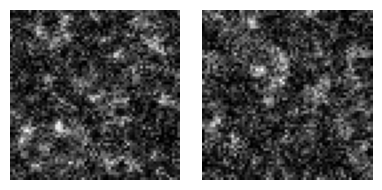

156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 509ms/step - i_loss: 0.1811 - n_loss: 0.0731 - kid: 0.0000e+00 - val_i_loss: 0.8679 - val_kid: 2.3565 - val_n_loss: 0.3312
Epoch 17/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1196 - n_loss: 0.0522

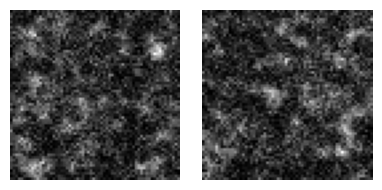

156/156 ━━━━━━━━━━━━━━━━━━━━ 171s 714ms/step - i_loss: 0.1196 - n_loss: 0.0522 - kid: 0.0000e+00 - val_i_loss: 0.7597 - val_kid: 2.3188 - val_n_loss: 0.2955
Epoch 18/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1265 - n_loss: 0.0546

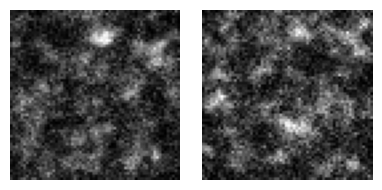

156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 722ms/step - i_loss: 0.1265 - n_loss: 0.0546 - kid: 0.0000e+00 - val_i_loss: 0.6497 - val_kid: 2.2865 - val_n_loss: 0.2601
Epoch 19/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.4720 - n_loss: 0.1688

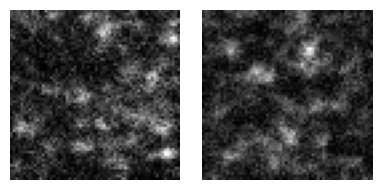

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 723ms/step - i_loss: 0.4714 - n_loss: 0.1686 - kid: 0.0000e+00 - val_i_loss: 0.5347 - val_kid: 2.1616 - val_n_loss: 0.2176
Epoch 20/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 0.9714 - n_loss: 0.3483

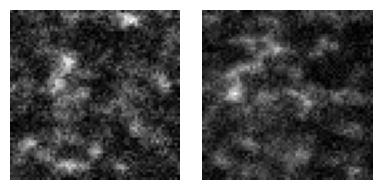

156/156 ━━━━━━━━━━━━━━━━━━━━ 111s 507ms/step - i_loss: 0.9695 - n_loss: 0.3477 - kid: 0.0000e+00 - val_i_loss: 0.4753 - val_kid: 1.9758 - val_n_loss: 0.1980
Epoch 21/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 0.1192 - n_loss: 0.0529

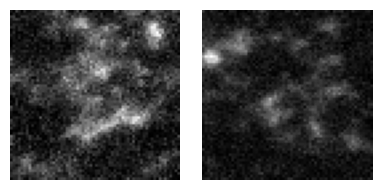

156/156 ━━━━━━━━━━━━━━━━━━━━ 171s 712ms/step - i_loss: 0.1192 - n_loss: 0.0529 - kid: 0.0000e+00 - val_i_loss: 0.3806 - val_kid: 1.7702 - val_n_loss: 0.1643
Epoch 22/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.1007 - n_loss: 0.0456

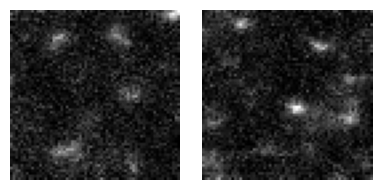

156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 719ms/step - i_loss: 0.1007 - n_loss: 0.0456 - kid: 0.0000e+00 - val_i_loss: 0.3179 - val_kid: 1.7271 - val_n_loss: 0.1398
Epoch 23/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1016 - n_loss: 0.0459

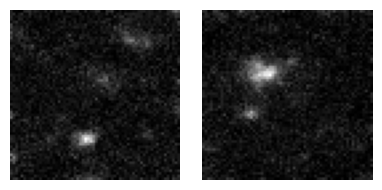

156/156 ━━━━━━━━━━━━━━━━━━━━ 111s 513ms/step - i_loss: 0.1016 - n_loss: 0.0459 - kid: 0.0000e+00 - val_i_loss: 0.2834 - val_kid: 1.7421 - val_n_loss: 0.1244
Epoch 24/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - i_loss: 0.0881 - n_loss: 0.0422

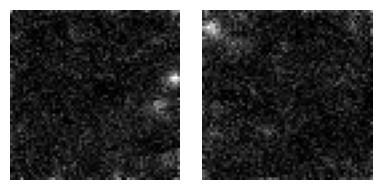

156/156 ━━━━━━━━━━━━━━━━━━━━ 141s 501ms/step - i_loss: 0.0881 - n_loss: 0.0422 - kid: 0.0000e+00 - val_i_loss: 0.2574 - val_kid: 1.8650 - val_n_loss: 0.1127
Epoch 25/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - i_loss: 0.0952 - n_loss: 0.0429

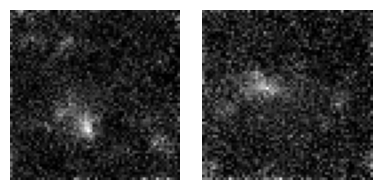

156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 713ms/step - i_loss: 0.0951 - n_loss: 0.0429 - kid: 0.0000e+00 - val_i_loss: 0.2418 - val_kid: 1.9954 - val_n_loss: 0.1033
Epoch 26/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 0.0836 - n_loss: 0.0409

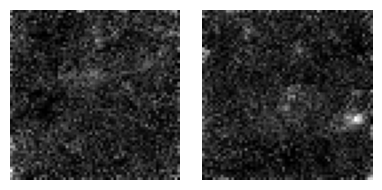

156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 712ms/step - i_loss: 0.0836 - n_loss: 0.0409 - kid: 0.0000e+00 - val_i_loss: 0.2281 - val_kid: 2.1027 - val_n_loss: 0.0965
Epoch 27/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.0835 - n_loss: 0.0412

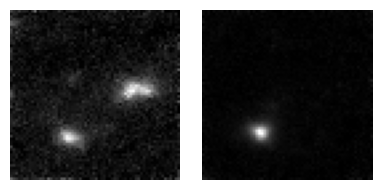

156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 505ms/step - i_loss: 0.0835 - n_loss: 0.0411 - kid: 0.0000e+00 - val_i_loss: 0.2161 - val_kid: 2.1585 - val_n_loss: 0.0897
Epoch 28/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - i_loss: 0.0816 - n_loss: 0.0402

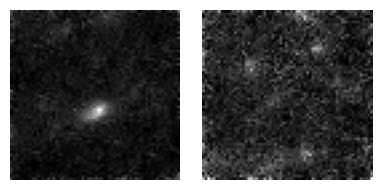

156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - i_loss: 0.0816 - n_loss: 0.0402 - kid: 0.0000e+00 - val_i_loss: 0.2025 - val_kid: 2.1827 - val_n_loss: 0.0837
Epoch 29/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - i_loss: 0.0823 - n_loss: 0.0399

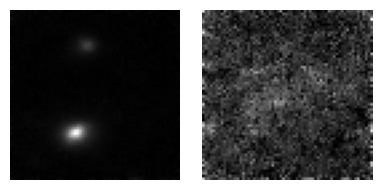

156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 517ms/step - i_loss: 0.0823 - n_loss: 0.0399 - kid: 0.0000e+00 - val_i_loss: 0.1850 - val_kid: 2.1582 - val_n_loss: 0.0778
Epoch 30/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - i_loss: 0.0842 - n_loss: 0.0390

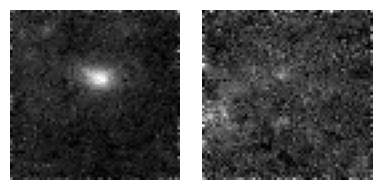

156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 487ms/step - i_loss: 0.0842 - n_loss: 0.0390 - kid: 0.0000e+00 - val_i_loss: 0.1693 - val_kid: 2.1996 - val_n_loss: 0.0720
Epoch 31/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - i_loss: 0.0794 - n_loss: 0.0389

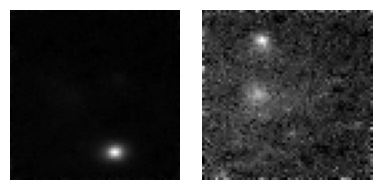

156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 473ms/step - i_loss: 0.0794 - n_loss: 0.0389 - kid: 0.0000e+00 - val_i_loss: 0.1569 - val_kid: 2.2398 - val_n_loss: 0.0671
Epoch 32/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - i_loss: 0.0771 - n_loss: 0.0380

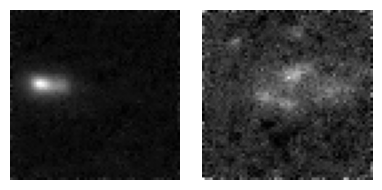

156/156 ━━━━━━━━━━━━━━━━━━━━ 80s 497ms/step - i_loss: 0.0771 - n_loss: 0.0380 - kid: 0.0000e+00 - val_i_loss: 0.1468 - val_kid: 2.1829 - val_n_loss: 0.0630
Epoch 33/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - i_loss: 0.7343 - n_loss: 0.2890

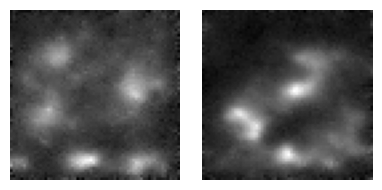

156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 480ms/step - i_loss: 0.7326 - n_loss: 0.2884 - kid: 0.0000e+00 - val_i_loss: 0.1658 - val_kid: 1.6158 - val_n_loss: 0.0790
Epoch 34/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - i_loss: 0.1113 - n_loss: 0.0517

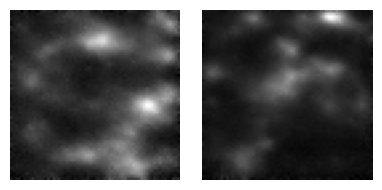

156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 708ms/step - i_loss: 0.1112 - n_loss: 0.0517 - kid: 0.0000e+00 - val_i_loss: 0.2016 - val_kid: 1.6066 - val_n_loss: 0.0949
Epoch 35/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - i_loss: 0.0947 - n_loss: 0.0437

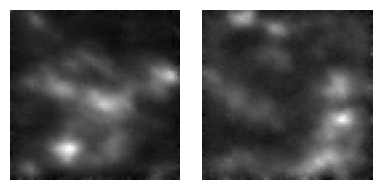

156/156 ━━━━━━━━━━━━━━━━━━━━ 106s 477ms/step - i_loss: 0.0947 - n_loss: 0.0437 - kid: 0.0000e+00 - val_i_loss: 0.2093 - val_kid: 1.6177 - val_n_loss: 0.1001
Epoch 36/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - i_loss: 0.0879 - n_loss: 0.0428

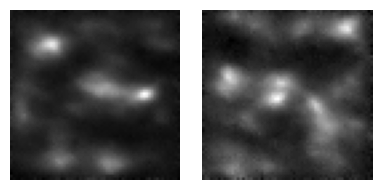

156/156 ━━━━━━━━━━━━━━━━━━━━ 117s 720ms/step - i_loss: 0.0879 - n_loss: 0.0428 - kid: 0.0000e+00 - val_i_loss: 0.2065 - val_kid: 1.6206 - val_n_loss: 0.0989
Epoch 37/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - i_loss: 0.0825 - n_loss: 0.0393

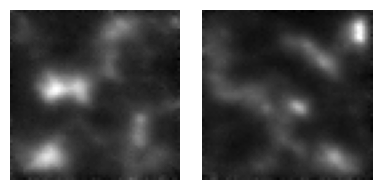

156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - i_loss: 0.0825 - n_loss: 0.0393 - kid: 0.0000e+00 - val_i_loss: 0.1964 - val_kid: 1.6198 - val_n_loss: 0.0951
Epoch 38/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.0814 - n_loss: 0.0397

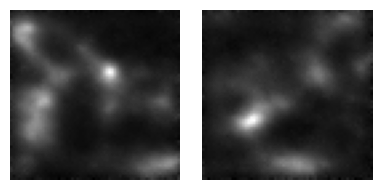

156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 502ms/step - i_loss: 0.0814 - n_loss: 0.0397 - kid: 0.0000e+00 - val_i_loss: 0.1879 - val_kid: 1.6083 - val_n_loss: 0.0896
Epoch 39/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - i_loss: 0.0790 - n_loss: 0.0378

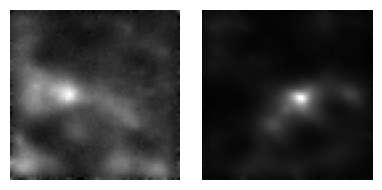

156/156 ━━━━━━━━━━━━━━━━━━━━ 78s 484ms/step - i_loss: 0.0790 - n_loss: 0.0378 - kid: 0.0000e+00 - val_i_loss: 0.1763 - val_kid: 1.6007 - val_n_loss: 0.0840
Epoch 40/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - i_loss: 0.2293 - n_loss: 0.0883

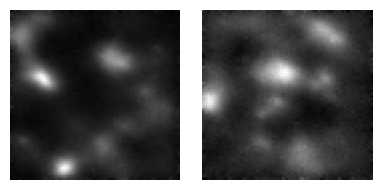

156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 700ms/step - i_loss: 0.2345 - n_loss: 0.0901 - kid: 0.0000e+00 - val_i_loss: 0.1704 - val_kid: 1.6130 - val_n_loss: 0.0808
Epoch 41/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 0.2931 - n_loss: 0.1409

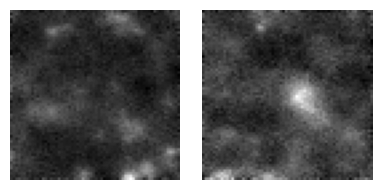

156/156 ━━━━━━━━━━━━━━━━━━━━ 144s 716ms/step - i_loss: 0.2926 - n_loss: 0.1406 - kid: 0.0000e+00 - val_i_loss: 0.1964 - val_kid: 1.7076 - val_n_loss: 0.1052
Epoch 42/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - i_loss: 0.1203 - n_loss: 0.0550

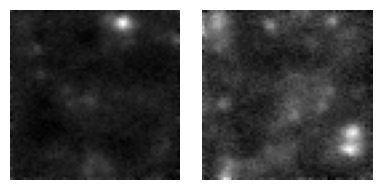

156/156 ━━━━━━━━━━━━━━━━━━━━ 111s 501ms/step - i_loss: 0.1202 - n_loss: 0.0550 - kid: 0.0000e+00 - val_i_loss: 0.1995 - val_kid: 1.7269 - val_n_loss: 0.1093
Epoch 43/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - i_loss: 0.1222 - n_loss: 0.0539

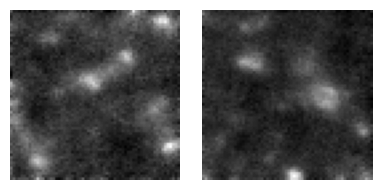

156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 703ms/step - i_loss: 0.1222 - n_loss: 0.0539 - kid: 0.0000e+00 - val_i_loss: 0.1897 - val_kid: 1.6935 - val_n_loss: 0.1052
Epoch 44/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 0.1479 - n_loss: 0.0613

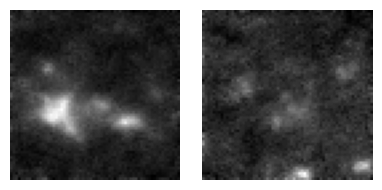

156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 714ms/step - i_loss: 0.1521 - n_loss: 0.0627 - kid: 0.0000e+00 - val_i_loss: 0.1756 - val_kid: 1.6943 - val_n_loss: 0.0980
Epoch 45/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - i_loss: 2.0248 - n_loss: 0.6991

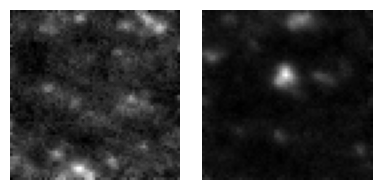

156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 503ms/step - i_loss: 2.0165 - n_loss: 0.6963 - kid: 0.0000e+00 - val_i_loss: 0.1745 - val_kid: 1.7114 - val_n_loss: 0.0983
Epoch 46/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - i_loss: 0.1393 - n_loss: 0.0590

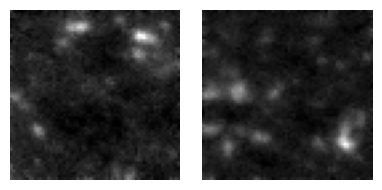

156/156 ━━━━━━━━━━━━━━━━━━━━ 172s 711ms/step - i_loss: 0.1403 - n_loss: 0.0593 - kid: 0.0000e+00 - val_i_loss: 0.1772 - val_kid: 1.6973 - val_n_loss: 0.0950
Epoch 47/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - i_loss: 1.5142 - n_loss: 0.5393

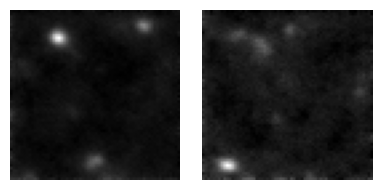

156/156 ━━━━━━━━━━━━━━━━━━━━ 114s 713ms/step - i_loss: 1.5102 - n_loss: 0.5379 - kid: 0.0000e+00 - val_i_loss: 0.2559 - val_kid: 1.7076 - val_n_loss: 0.1068
Epoch 48/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - i_loss: 0.1565 - n_loss: 0.0628

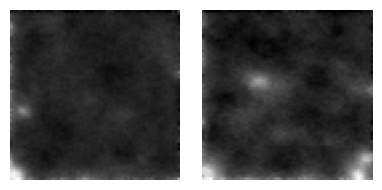

156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 501ms/step - i_loss: 0.1586 - n_loss: 0.0635 - kid: 0.0000e+00 - val_i_loss: 0.3675 - val_kid: 2.2064 - val_n_loss: 0.1287
Epoch 49/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - i_loss: 1.7872 - n_loss: 0.5986

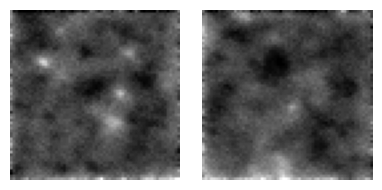

156/156 ━━━━━━━━━━━━━━━━━━━━ 113s 704ms/step - i_loss: 1.7806 - n_loss: 0.5964 - kid: 0.0000e+00 - val_i_loss: 0.3715 - val_kid: 1.7743 - val_n_loss: 0.1305
Epoch 50/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - i_loss: 0.1236 - n_loss: 0.0519

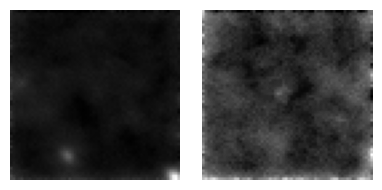

156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 713ms/step - i_loss: 0.1236 - n_loss: 0.0519 - kid: 0.0000e+00 - val_i_loss: 0.3651 - val_kid: 1.8367 - val_n_loss: 0.1287


In [29]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

## Inference and Results

By running the training for at least 50 epochs (takes 2 hours on a T4 GPU, we get high quality image generations using this code example.

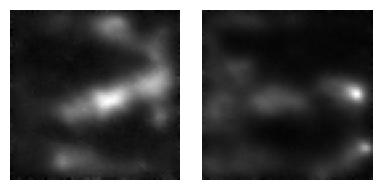

In [30]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()